# IMPORTING THE REQUIRED LIBRARIES

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.ticker import MultipleLocator
import xgboost as xgba

# LOADING THE DATASET

In [2]:
training_df = pd.read_csv( r'C:\Users\SUSHIL\Desktop\STORE ITEM D.F.C\train.csv')
testing_df = pd.read_csv( r'C:\Users\SUSHIL\Desktop\STORE ITEM D.F.C\test.csv')
sample_submission_df = pd.read_csv(r'C:\Users\SUSHIL\Desktop\STORE ITEM D.F.C\sample_submission.csv')

In [3]:
train_df= training_df
test_df= testing_df

In [4]:
train_df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [5]:
test_df.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


# PERFORMING THE EDA ( Exploratory Data Analysis )

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [7]:
train_df.dtypes

date     object
store     int64
item      int64
sales     int64
dtype: object

In [8]:
# Loop through columns and check data types
numeric_columns = []
for column in train_df.columns:
    if pd.api.types.is_numeric_dtype(train_df[column]):
        numeric_columns.append(column)

In [9]:
print("Numeric Columns:")
print(numeric_columns)

Numeric Columns:
['store', 'item', 'sales']


### VISUALIZING THE DATA TO UNNDERSTAND ITS DISTRIBUTION AND RELATIONSHIPS.

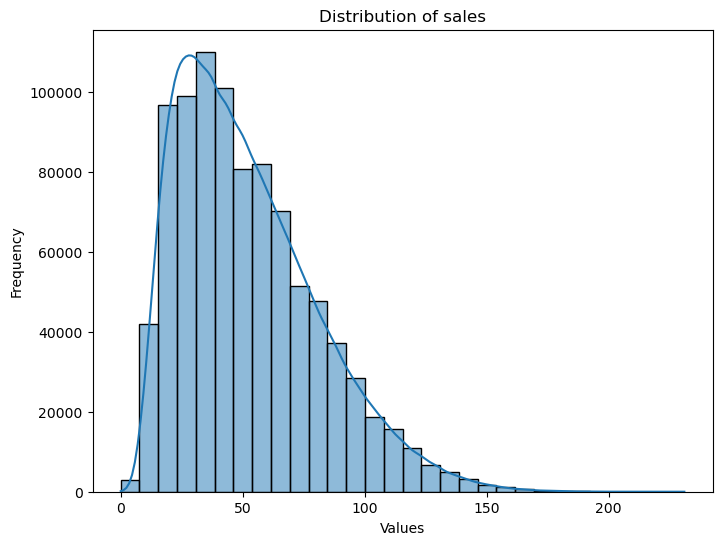

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example: Histogram of a numerical column
plt.figure(figsize=(8, 6))
sns.histplot(train_df['sales'], bins=30, kde=True)
plt.title('Distribution of sales')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()

### VISUALIZING THE CORRELATION BETWEEN NUMERICAL FEATURES USING A CORRELATION MATRIX.

C:\Users\SUSHIL\AppData\Local\Temp\ipykernel_28352\545075950.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = train_df.corr()


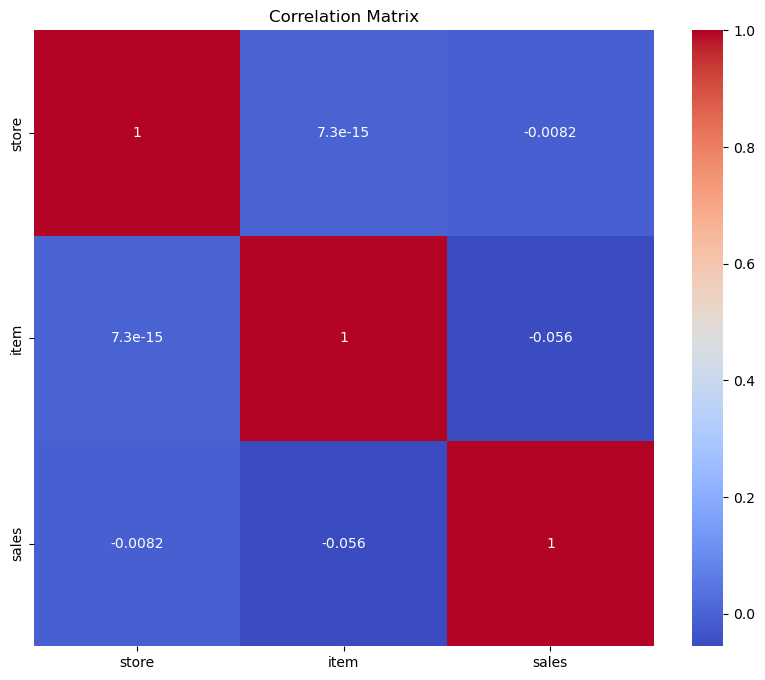

In [11]:
correlation_matrix = train_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

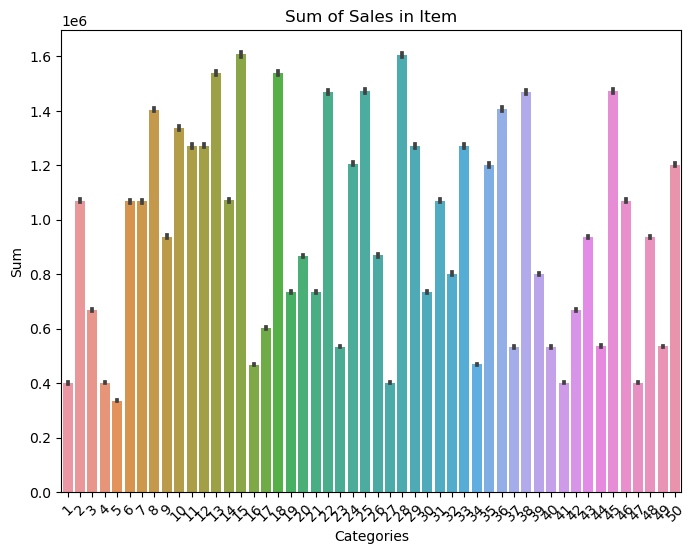

In [12]:
# Assuming 'date' is the name of categorical column
plt.figure(figsize=(8, 6))
sns.barplot(x='item', y='sales', data=train_df, estimator=sum)  # You may need to specify 'y' and 'estimator' based on your data
plt.title('Sum of Sales in Item')
plt.xlabel('Categories')
plt.ylabel('Sum')
plt.xticks(rotation=45)
plt.show()

## DROP ROWS WITH MISSING VALUES

In [13]:
train_df.dropna(inplace=True)

In [14]:
train_df

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [15]:
train_df.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [16]:
test_df.isnull().sum()

id       0
date     0
store    0
item     0
dtype: int64

since there is no missing values.

## CONVERTING THE STRING INTO DATETIME COLUMN

In [17]:
train_df['date']=pd.to_datetime(train_df['date'])
test_df['date']=pd.to_datetime(test_df['date'])

In [18]:
train_df.dtypes

date     datetime64[ns]
store             int64
item              int64
sales             int64
dtype: object

In [19]:
train_df["date"].min(), train_df["date"].max(), test_df["date"].min(), test_df["date"].max()

(Timestamp('2013-01-01 00:00:00'),
 Timestamp('2017-12-31 00:00:00'),
 Timestamp('2018-01-01 00:00:00'),
 Timestamp('2018-03-31 00:00:00'))

In [20]:
train_df.store.nunique(), test_df.store.nunique(), train_df.item.nunique(), test_df.item.nunique()

(10, 10, 50, 50)

In [21]:
train_df.groupby(["store"])["item"].nunique()

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

### DESCRIPTIVE STATISTICS

In [22]:
train_df.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [23]:
#store wise
train_df.groupby(["store"]).agg({"sales": ["count","sum", "mean", "median", "std", "min", "max"]})

sales                                               
       count      sum       mean median        std min  max
store                                                      
1      91300  4315603  47.268379   44.0  24.006252   1  155
2      91300  6120128  67.033165   62.0  33.595810   3  231
3      91300  5435144  59.530602   55.0  29.974102   3  196
4      91300  5012639  54.902946   51.0  27.733097   4  186
5      91300  3631016  39.770164   37.0  20.365757   2  130
6      91300  3627670  39.733516   37.0  20.310451   0  134
7      91300  3320009  36.363735   34.0  18.684825   1  122
8      91300  5856169  64.142048   60.0  32.231751   4  204
9      91300  5025976  55.049025   51.0  27.832186   4  195
10     91300  5360158  58.709288   54.0  29.554994   3  187

In [24]:
# item wise
train_df.groupby(["item"]).agg({"sales": ["count","sum", "mean", "median", "std", "min", "max"]})

sales                                               
      count      sum       mean median        std min  max
item                                                      
1     18260   401384  21.981599   21.0   8.468922   1   59
2     18260  1069564  58.574151   56.0  20.093015   9  150
3     18260   669087  36.642223   35.0  13.179441   7  104
4     18260   401907  22.010241   21.0   8.403898   0   66
5     18260   335230  18.358708   18.0   7.265167   1   50
6     18260  1068281  58.503888   56.0  20.174898  11  148
7     18260  1068777  58.531051   56.0  20.146002  11  141
8     18260  1405108  76.950055   74.0  26.130697  15  181
9     18260   938379  51.389869   49.5  17.790158   6  134
10    18260  1337133  73.227437   70.0  24.823725  14  175
11    18260  1271925  69.656353   67.0  23.744732  11  170
12    18260  1271534  69.634940   67.0  23.738663  12  170
13    18260  1539621  84.316594   81.0  28.311031  20  210
14    18260  1071531  58.681873   56.0  20.079860  12  152
15    18260  1607442  88.030778   85.0  29.522852  17  231
16    18260   468480  25.656079   25.0   9.603270   2   70
17    18260   602486  32.994852   32.0  11.967610   4   83
18    18260  1538876  84.275794   81.0  28.430621  18  208
19    18260   736892  40.355531   39.0  14.332645   5   99
20    18260   867641  47.515936   46.0  16.490487   9  127
21    18260   736190  40.317087   39.0  14.338006   7  109
22    18260  1469971  80.502245   78.0  27.118163  14  214
23    18260   534979  29.297864   28.0  10.819549   3   81
24    18260  1205975  66.044633   64.0  22.531555  14  156
25    18260  1473334  80.686418   78.0  27.238817  18  193
26    18260   869981  47.644085   46.0  16.723912   8  119
27    18260   402628  22.049726   21.0   8.461641   1   59
28    18260  1604713  87.881325   85.0  29.501781  16  206
29    18260  1271240  69.618839   67.0  23.635631  15  173
30    18260   736554  40.337021   39.0  14.363331   5  115
31    18260  1070845  58.644304   57.0  20.104705  10  159
32    18260   803107  43.981763   42.0  15.574556   5  119
33    18260  1270183  69.560953   67.0  23.718343  15  169
34    18260   469935  25.735761   25.0   9.617910   2   79
35    18260  1201541  65.801807   63.0  22.461990  12  168
36    18260  1406548  77.028916   74.0  26.067440  16  188
37    18260   534258  29.258379   28.0  10.771547   3   74
38    18260  1470330  80.521906   77.0  27.141799  15  188
39    18260   801311  43.883406   42.0  15.511550   7  112
40    18260   534094  29.249398   28.0  10.822959   3   74
41    18260   401759  22.002136   21.0   8.402470   2   60
42    18260   669925  36.688116   35.0  13.215112   5   96
43    18260   936635  51.294359   49.0  17.801008   9  126
44    18260   536811  29.398193   28.0  10.797738   3   78
45    18260  1471467  80.584173   78.0  27.318402  18  205
46    18260  1070764  58.639869   56.0  20.220879  11  150
47    18260   401781  22.003341   21.0   8.420102   2   61
48    18260   937703  51.352848   49.0  17.881917   8  130
49    18260   535663  29.335323   28.0  10.874788   3   77
50    18260  1203009  65.882202   63.0  22.416031  12  164

### STORE SALES HISTOGRAM

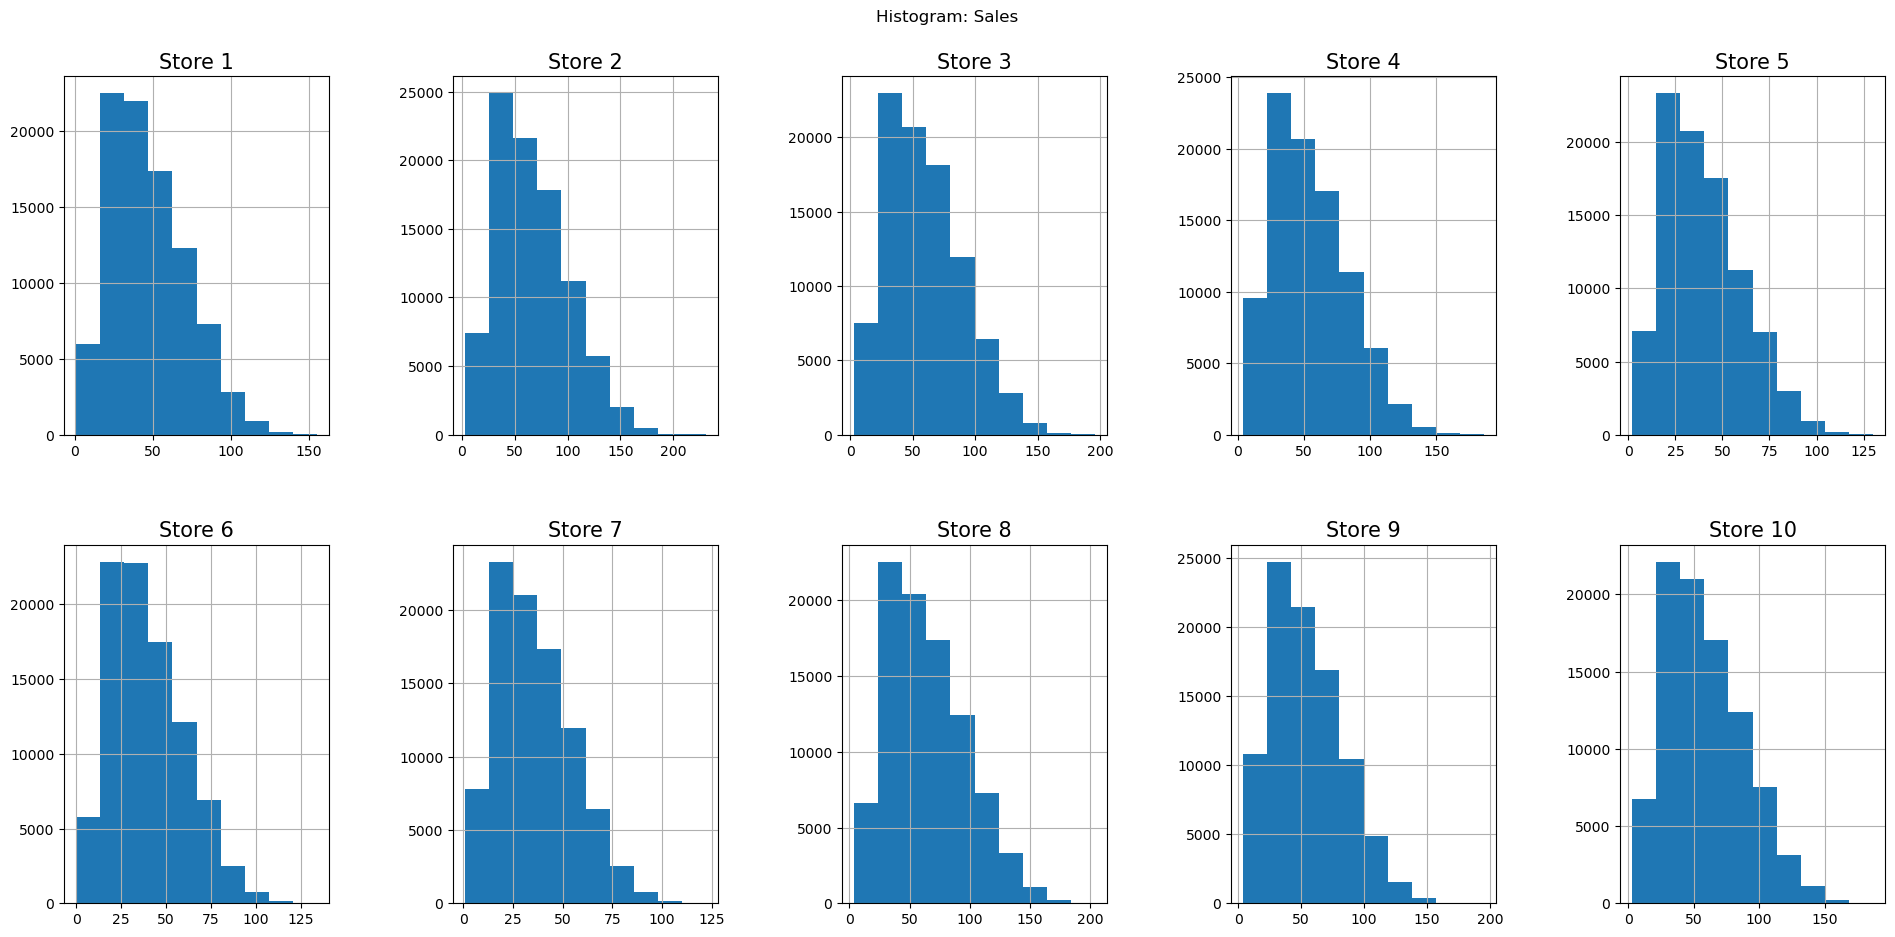

In [25]:
# Create a 2x5 grid of subplots (2 rows, 5 columns)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

# Loop through store numbers from 1 to 10
for i in range(1, 11):
    if i < 6:
        # For the first row of subplots (top row)
        train_df[train_df.store == i].sales.hist(ax=axes[0, i - 1])
        axes[0, i - 1].set_title("Store " + str(i), fontsize=15)
    else:
        # For the second row of subplots (bottom row)
        train_df[train_df.store == i].sales.hist(ax=axes[1, i - 6])
        axes[1, i - 6].set_title("Store " + str(i), fontsize=15)

# Add space between subplots
plt.tight_layout(pad=4.5)

# Add a title to the entire figure
plt.suptitle("Histogram: Sales")

# Show the plot
plt.show()


### ITEM_WISE SALES HISTOGRAM

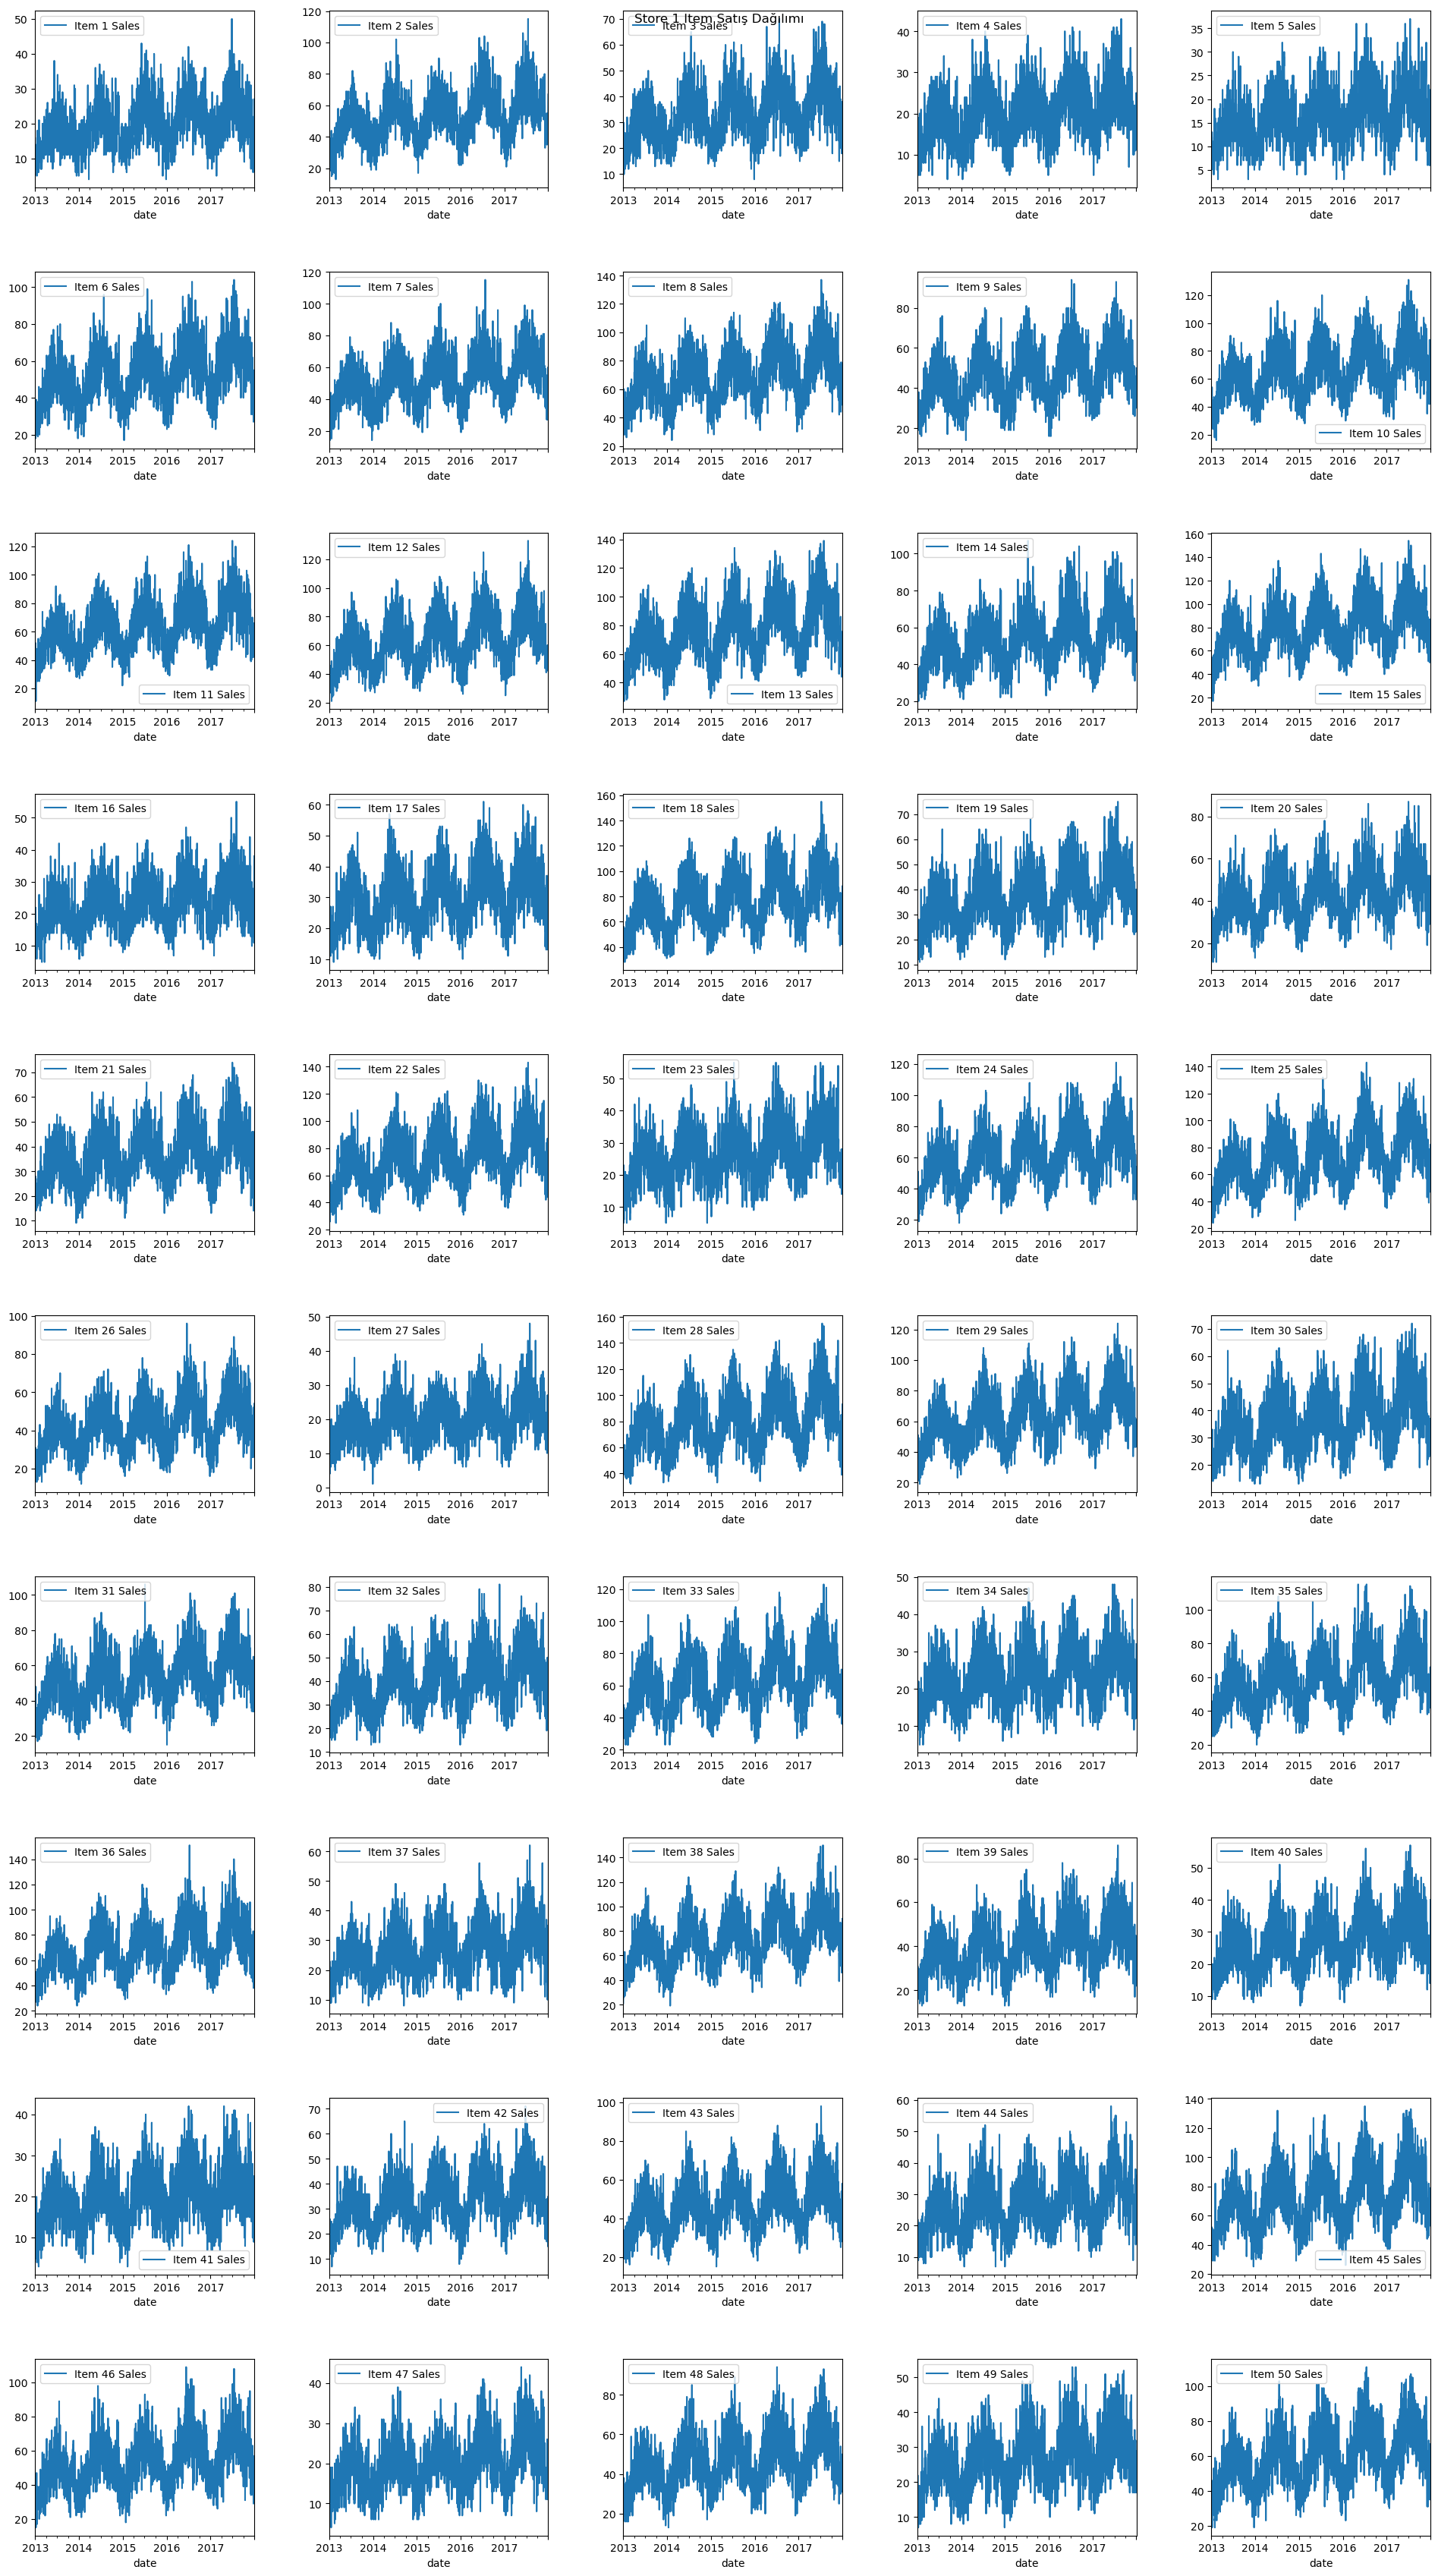

In [26]:
store = 1 
sub = train_df[train_df.store == store].set_index("date") 
fig, axes = plt.subplots(10, 5, figsize=(20, 35)) 
for i in range(1,51): 
    if i < 6: 
        sub[sub.item == i].sales.plot(ax=axes[0, i-1], legend=True, label = "Item "+str(i)+" Sales") 
    if i >= 6 and i<11: 
        sub[sub.item == i].sales.plot(ax=axes[1, i - 6], legend=True, label = "Item "+str(i)+" Sales") 
    if i >= 11 and i<16: 
        sub[sub.item == i].sales.plot(ax=axes[2, i - 11], legend=True, label = "Item "+str(i)+" Sales") 
    if i >= 16 and i<21: 
        sub[sub.item == i].sales.plot(ax=axes[3, i - 16], legend=True, label = "Item "+str(i)+" Sales") 
    if i >= 21 and i<26: 
        sub[sub.item == i].sales.plot(ax=axes[4, i - 21], legend=True, label = "Item "+str(i)+" Sales") 
    if i >= 26 and i<31: 
        sub[sub.item == i].sales.plot(ax=axes[5, i - 26], legend=True, label = "Item "+str(i)+" Sales") 
    if i >= 31 and i<36: 
        sub[sub.item == i].sales.plot(ax=axes[6, i - 31], legend=True, label = "Item "+str(i)+" Sales") 
    if i >= 36 and i<41: 
        sub[sub.item == i].sales.plot(ax=axes[7, i - 36], legend=True, label = "Item "+str(i)+" Sales") 
    if i >= 41 and i<46: 
        sub[sub.item == i].sales.plot(ax=axes[8, i - 41], legend=True, label = "Item "+str(i)+" Sales") 
    if i >= 46 and i<51: 
        sub[sub.item == i].sales.plot(ax=axes[9, i - 46], legend=True, label = "Item "+str(i)+" Sales") 
                
plt.tight_layout(pad=4.5)
plt.suptitle("Store 1 Item Satış Dağılımı");

## SALES COUNT HISTOGRAM

<Axes: >

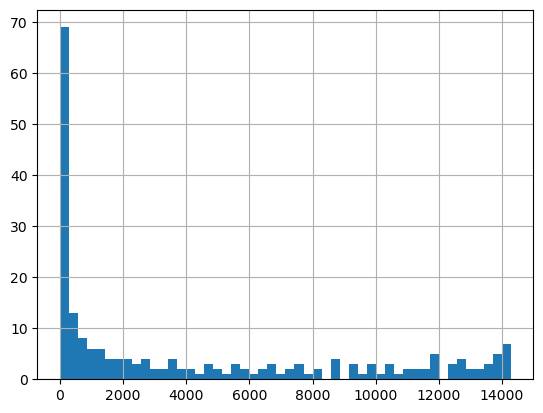

In [27]:
train_df['sales'].value_counts().hist(bins=50)

In [28]:
round(train_df['sales'].sum()) # TOTAL REVENUE GENERATED.

47704512

In [29]:
import statsmodels.api as sm

def make_demand_stationary(data):
    stationary_data = pd.DataFrame()

    for item in data.columns:
        item_series = data[item]
        result = sm.tsa.adfuller(item_series, autolag='AIC')

        if result[1] > 0.05:
            # If p-value > 0.05, the series is not stationary; apply differencing
            diff_series = item_series - item_series.shift(1)
            diff_series.dropna(inplace=True)
            stationary_data[item] = diff_series
        else:
            # If p-value <= 0.05, the series is stationary
            stationary_data[item] = item_series

            
    return stationary_data

In [30]:
import warnings

# Filter out all warnings
warnings.filterwarnings("ignore")

# Replace 'your_data.csv' with your data file's path
data_chunk_iterator = pd.read_csv(r'C:\Users\SUSHIL\Desktop\STORE ITEM D.F.C\train.csv', chunksize=1000)  # Adjust chunksize as needed

# Initialize an empty DataFrame to store stationary data
stationary_data = pd.DataFrame()

# Iterate through data chunks
for chunk in data_chunk_iterator:
    chunk['date'] = pd.to_datetime(chunk['date'])
    chunk.set_index('date', inplace=True)

    # Apply the make_demand_stationary function to the current chunk
    chunk_stationary = make_demand_stationary(chunk)

    # Append the stationary data for this chunk to the overall stationary_data DataFrame
    stationary_data = stationary_data.append(chunk_stationary)

# Now, stationary_data contains the stationary time series for the entire dataset in smaller chunks

In [31]:
stationary_data=stationary_data.iloc[1:]
stationary_data.head()

,store,item,sales
date,,,
2013-01-02,1.0,1.0,-2.0
2013-01-03,1.0,1.0,3.0
2013-01-04,1.0,1.0,-1.0
2013-01-05,1.0,1.0,-3.0
2013-01-06,1.0,1.0,2.0


In [32]:
stationary_data.reset_index(inplace=True)
stationary_data.head()

,date,store,item,sales
0,2013-01-02,1.0,1.0,-2.0
1,2013-01-03,1.0,1.0,3.0
2,2013-01-04,1.0,1.0,-1.0
3,2013-01-05,1.0,1.0,-3.0
4,2013-01-06,1.0,1.0,2.0


In [33]:
#stationary_data.drop('index',axis=1,inplace=True)

In [34]:
testing_df = testing_df.drop('id',axis=1)
testing_df['date'] = pd.to_datetime(testing_df['date'])
testing_df.head()

,date,store,item
0,2018-01-01,1,1
1,2018-01-02,1,1
2,2018-01-03,1,1
3,2018-01-04,1,1
4,2018-01-05,1,1


In [35]:
#chunk['date'] = pd.to_datetime(chunk['date'])
stationary_data.dtypes

date     datetime64[ns]
store           float64
item            float64
sales           float64
dtype: object

# FEATURE ENGINEERING

In [36]:

# Concatenate the training and testing dataframes
df_combined = pd.concat([stationary_data, testing_df]).reset_index(drop=True)

def create_date_features(dataframe):
    dataframe['month'] = dataframe.date.dt.month
    dataframe['day_of_month'] = dataframe.date.dt.day
    dataframe['day_of_year'] = dataframe.date.dt.dayofyear
    dataframe['week_of_year'] = dataframe.date.dt.weekofyear
    dataframe['day_of_week'] = dataframe.date.dt.dayofweek + 1
    dataframe['year'] = dataframe.date.dt.year
    dataframe['is_wknd'] = dataframe.date.dt.weekday // 4
    dataframe['is_month_start'] = dataframe.date.dt.is_month_start.astype(int)
    dataframe['is_month_end'] = dataframe.date.dt.is_month_end.astype(int)
    dataframe['quarter'] = dataframe.date.dt.quarter
    dataframe['week_block_num'] = [int(x) for x in np.floor((dataframe.date - pd.to_datetime('2012-12-31')).dt.days / 7) + 1]
    dataframe['quarter_block_num'] = (dataframe['year'] - 2013) * 4 + dataframe['quarter']
    dataframe['week_of_month'] = dataframe['week_of_year'].values // 4.35
    return dataframe

In [37]:
testing_df.shape

(45000, 3)

In [38]:
stationary_data.shape

(912554, 4)

In [39]:
df_combined.isnull().sum()

date         0
store        0
item         0
sales    45461
dtype: int64

In [40]:
df_combined = create_date_features(df_combined)                                   

In [41]:
# One-Hot Encoding                                                                                                                            
df_dum = pd.get_dummies(df_combined[['store', 'item', 'day_of_week', 'month', ]], columns=['store', 'item', 'day_of_week', 'month', ], dummy_na=True)  
df_combined = pd.concat([df_combined, df_dum], axis=1) 

# Create lagged features
for lag in [90, 180, 270, 360]:  # approximate days for 3, 6, 9 and 12 months
    df_combined[f'sales_lag_{lag}'] = df_combined.groupby(['store', 'item'])['sales'].shift(lag)

In [42]:
# Create lagged features
for lag in [90, 180, 270, 360]:  # approximate days for 3, 6, 9 and 12 months
    df_combined[f'sales_lag_{lag}'] = df_combined.groupby(['store', 'item'])['sales'].shift(lag)

# MODEL DEVELOPMENT - MODEL TRAINING AND TUNING

In [43]:
print(df_combined.shape)
print(stationary_data.shape)
print(testing_df.shape)

(957554, 107)
(912554, 4)
(45000, 3)


In [44]:
df_combined.isnull().sum()

date                  0
store                 0
item                  0
sales             45461
month                 0
                  ...  
month_nan             0
sales_lag_90      50095
sales_lag_180     96791
sales_lag_270    143491
sales_lag_360    190201
Length: 107, dtype: int64

In [45]:
df_train = df_combined.loc[~df_combined.sales.isna()]
df_test = df_combined.loc[df_combined.sales.isna()]      
#df_train = df_train.drop("id",axis = 1)
df_train = df_train.dropna()
df_train.head()

,date,store,item,sales,month,day_of_month,day_of_year,week_of_year,day_of_week,year,...,month_8.0,month_9.0,month_10.0,month_11.0,month_12.0,month_nan,sales_lag_90,sales_lag_180,sales_lag_270,sales_lag_360
360,2013-12-28,1.0,1.0,-1.0,12,28,362,52,6,2013,...,0,0,0,0,1,0,7.0,-1.0,8.0,-2.0
361,2013-12-29,1.0,1.0,-3.0,12,29,363,52,7,2013,...,0,0,0,0,1,0,0.0,-6.0,5.0,3.0
362,2013-12-30,1.0,1.0,-9.0,12,30,364,1,1,2013,...,0,0,0,0,1,0,-8.0,-5.0,-6.0,-1.0
363,2013-12-31,1.0,1.0,10.0,12,31,365,1,2,2013,...,0,0,0,0,1,0,-1.0,12.0,1.0,-3.0
364,2014-01-01,1.0,1.0,-6.0,1,1,1,1,3,2014,...,0,0,0,0,0,0,3.0,-7.0,4.0,2.0


# MODEL TESTING

In [46]:
from sklearn.model_selection import TimeSeriesSplit
from lightgbm import LGBMRegressor

# Number of splits
n_splits = 5

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits)

model = LGBMRegressor(learning_rate = 0.1)
df_fc = df_train.copy()
smape_values = []
feature_importance_df = pd.DataFrame(columns=df_train.drop(["sales", "date"], axis=1).columns)  # Initialize a DataFrame to store feature importances

# Calculate SMAPE
def smape(y_true, y_pred):
    return 100.0/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def lgbm_smape(preds, train_data):
    #labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(train_data))
    return 'SMAPE', smape_val

# Perform cross-validation
for train_index, test_index in tscv.split(df_train):
    CV_train, CV_test = df_train.iloc[train_index], df_train.iloc[test_index]

    # Fit the model on the training data
    model.fit(CV_train.drop(["sales", "date"], axis=1), CV_train["sales"])

    # Predict on the test data
    predictions = model.predict(CV_test.drop(["sales", "date"], axis=1))
    df_fc.loc[df_train.iloc[test_index].index,"predictions"] = predictions[0]
    # Calculate SMAPE and add it to the list of SMAPE values
    smape_value = lgbm_smape(CV_test["sales"].values, predictions)
    smape_values.append(smape_value)
    feature_importance_df = feature_importance_df.append(pd.Series(model.feature_importances_, 
                                                                   index=feature_importance_df.columns), ignore_index=True)
# Print the average SMAPE value across all folds
smape_values

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1488
[LightGBM] [Info] Number of data points in the train set: 120864, number of used features: 59
[LightGBM] [Info] Start training from score 1.019526
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1590
[LightGBM] [Info] Number of data points in the train set: 241726, number of used features: 67
[LightGBM] [Info] Start training from score 0.731700
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

[('SMAPE', 155.1897800345095),
 ('SMAPE', 157.72507044765078),
 ('SMAPE', 157.03855854721175),
 ('SMAPE', 155.30304636123626),
 ('SMAPE', 155.40932215735424)]

In [47]:
# Print the average SMAPE value across all folds
average_smape = np.mean([smape_val[1] for smape_val in smape_values])
print(f"Average SMAPE: {average_smape}")

Average SMAPE: 156.13315550959254


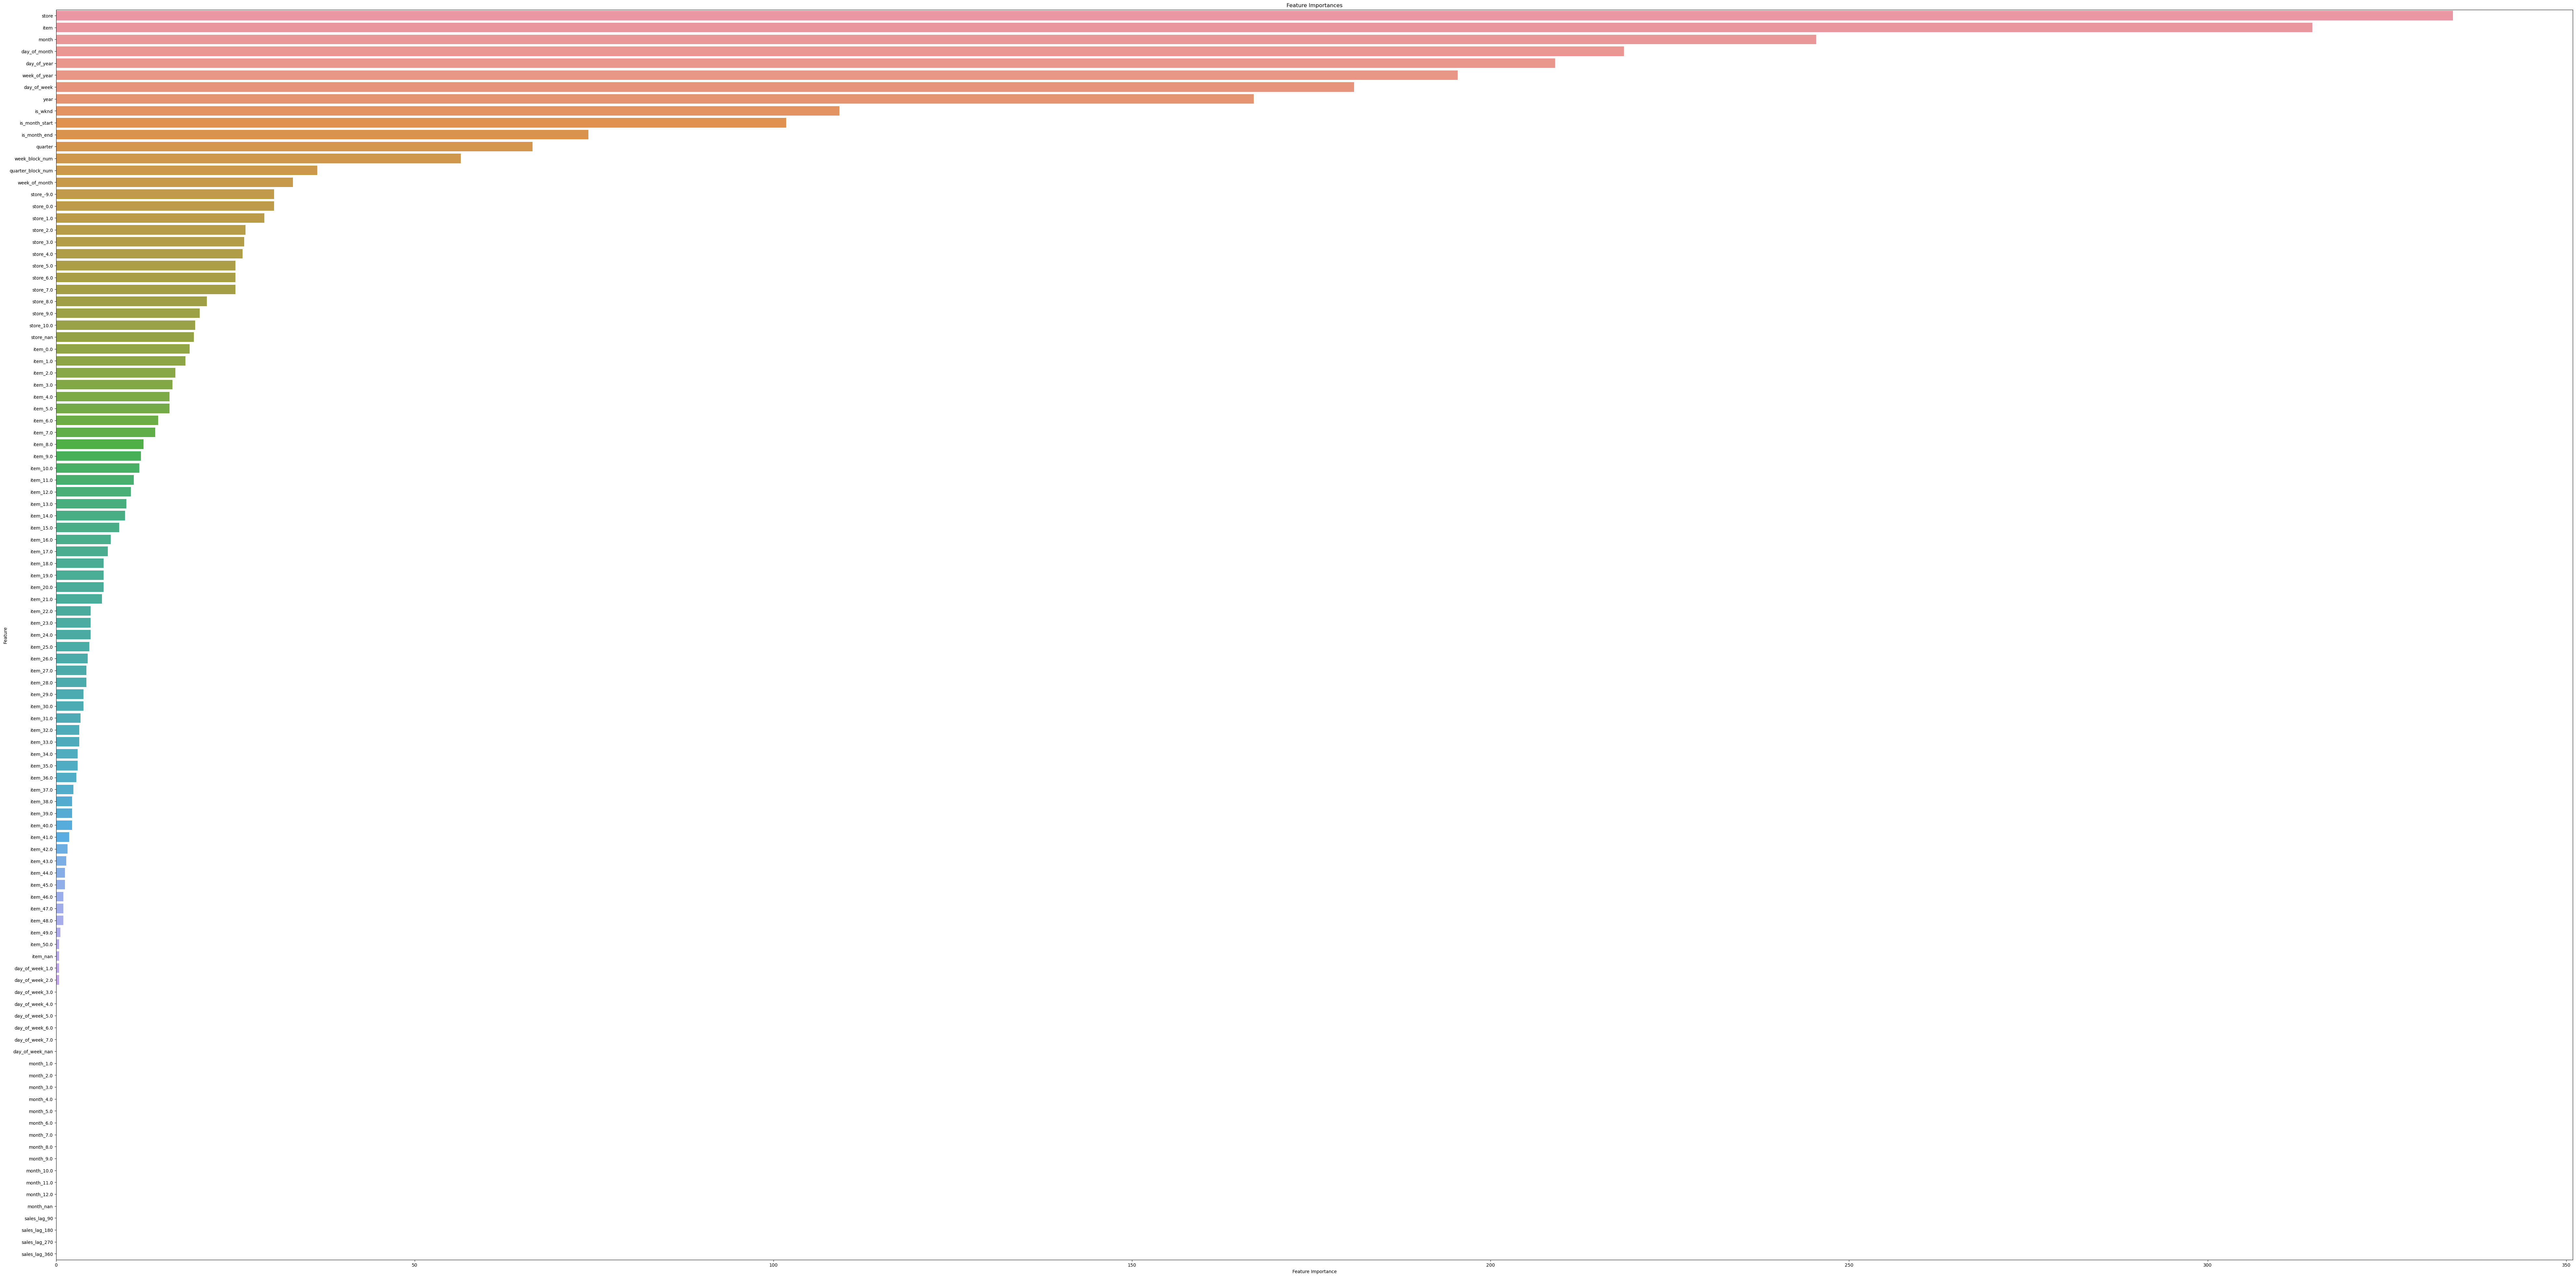

In [48]:
# Plot feature importances
plt.figure(figsize=(100, 50))
sns.barplot(x=feature_importance_df.mean().sort_values(ascending=False), y=feature_importance_df.columns)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

In [49]:
df_fc

,date,store,item,sales,month,day_of_month,day_of_year,week_of_year,day_of_week,year,...,month_9.0,month_10.0,month_11.0,month_12.0,month_nan,sales_lag_90,sales_lag_180,sales_lag_270,sales_lag_360,predictions
360,2013-12-28,1.0,1.0,-1.0,12,28,362,52,6,2013,...,0,0,0,1,0,7.0,-1.0,8.0,-2.0,NaN
361,2013-12-29,1.0,1.0,-3.0,12,29,363,52,7,2013,...,0,0,0,1,0,0.0,-6.0,5.0,3.0,NaN
362,2013-12-30,1.0,1.0,-9.0,12,30,364,1,1,2013,...,0,0,0,1,0,-8.0,-5.0,-6.0,-1.0,NaN
363,2013-12-31,1.0,1.0,10.0,12,31,365,1,2,2013,...,0,0,0,1,0,-1.0,12.0,1.0,-3.0,NaN
364,2014-01-01,1.0,1.0,-6.0,1,1,1,1,3,2014,...,0,0,0,0,0,3.0,-7.0,4.0,2.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912549,2017-12-27,10.0,50.0,22.0,12,27,361,52,3,2017,...,0,0,0,1,0,2.0,-10.0,32.0,5.0,1.966393
912550,2017-12-28,10.0,50.0,-4.0,12,28,362,52,4,2017,...,0,0,0,1,0,8.0,7.0,9.0,-29.0,1.966393
912551,2017-12-29,10.0,50.0,15.0,12,29,363,52,5,2017,...,0,0,0,1,0,13.0,1.0,-46.0,23.0,1.966393
912552,2017-12-30,10.0,50.0,-12.0,12,30,364,52,6,2017,...,0,0,0,1,0,-4.0,-21.0,42.0,0.0,1.966393


In [50]:
df_test_copy = df_test.drop(["sales","date"], axis = 1)

In [51]:
predictions = []

# Create a separate DataFrame to store the lagged predictions
lagged_predictions = df_test_copy.copy()

# Iterate over the test set
for i in range(len(df_test_copy)):
    # Prepare the data for the current day, including lagged features
    data = lagged_predictions.iloc[i:i+1].copy()
    
    # Make a prediction for the current day
    prediction = model.predict(data)
    
    # Store the prediction
    predictions.append(prediction[0])
    
#     # If there are still more days to predict, update the necessary lagged features in the lagged_predictions DataFrame
#     if i < len(df_test) - 1:
#         for j in range(1, 31):
#             if i + j < len(df_test):
#                 lagged_predictions.loc[i + j, f'lag_{j}'] = prediction[0]

# Convert the list of predictions to a DataFrame or series, if necessary
predictions = predictions[:45000]
predictions = pd.Series(predictions)

In [52]:
 predictions

0       -12.872969
1         1.541857
2         2.538001
3         2.149774
4        -0.312032
           ...    
44995     1.905901
44996     4.062221
44997     5.555301
44998   -11.392820
44999     4.899110
Length: 45000, dtype: float64

In [61]:
np.abs(predictions)

0        12.872969
1         1.541857
2         2.538001
3         2.149774
4         0.312032
           ...    
44995     1.905901
44996     4.062221
44997     5.555301
44998    11.392820
44999     4.899110
Length: 45000, dtype: float64

In [62]:
#load test set
df_test = pd.read_csv( r'C:\Users\SUSHIL\Desktop\STORE ITEM D.F.C\test.csv')
df_test["date"] = pd.to_datetime(df_test["date"])
df_test.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


In [63]:
# Add predictions to the test dataframe
df_test['predictions'] = np.abs(predictions.values)
df_test

,id,date,store,item,predictions
0,0,2018-01-01,1,1,12.872969
1,1,2018-01-02,1,1,1.541857
2,2,2018-01-03,1,1,2.538001
3,3,2018-01-04,1,1,2.149774
4,4,2018-01-05,1,1,0.312032
...,...,...,...,...,...
44995,44995,2018-03-27,10,50,1.905901
44996,44996,2018-03-28,10,50,4.062221
44997,44997,2018-03-29,10,50,5.555301
44998,44998,2018-03-30,10,50,11.392820


In [65]:
df_test.to_csv('df_test.csv', index=False)